In [1]:
import sys
sys.path.append("../")

import pickle

import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import sklearn
from sklearn import linear_model
import torch

from cvae.vae import VAE
from envs.panda_center_out import PandaCenterOutEnv
import pandas as pd


Bad key “backend in file /Users/kenfuliang/.matplotlib/matplotlibrc, line 1 ('“backend: TkAgg”')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
torch.manual_seed(0)

# Analysis the data
- One trial per target. There are 8 trials in total.
- Sanity check: joints_vel is correct, meaning I can reproduce the end-effector position sequence from joints_vel 

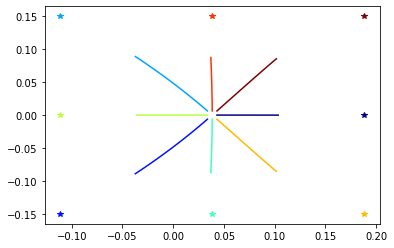

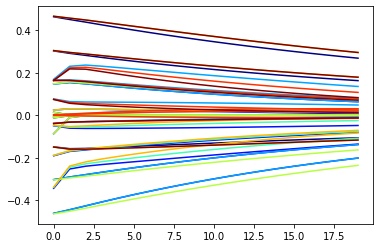

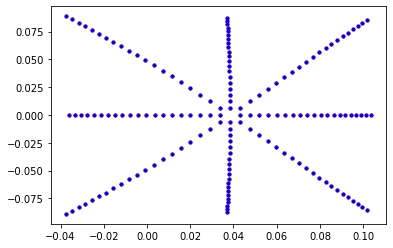

In [3]:
class Dataset:
    def __init__(self,data):
        self.data = data
        self.df = pd.DataFrame(data)
        self.uniqueTargets = self.df['target'].unique()
        self.colorOfTarget = self._colorOfTarget()
    def _colorOfTarget(self):                                                                                                                                                                            
        '''
        set specific color for each target to have better visualization
        '''
        ## color setting for each target
        n = len(self.uniqueTargets)
        colors = plt.cm.jet(np.linspace(0,1,n))
        df = self.df
        rt = {}
        for ii,target in enumerate(self.uniqueTargets):
            trials=[]
            rt[tuple(target)] = colors[ii]
        return rt
    def PlotTargets(self):
        df = self.df
        for ii,target in enumerate(self.uniqueTargets):
            color = self.colorOfTarget[target]
            x = self.uniqueTargets[ii][0]
            y = self.uniqueTargets[ii][1]
            plt.plot(x,y,'*',color=color)
    def PlotEndEffectorMovements(self):
#         fig,ax=plt.subplots()
        df = self.df
        for ii in range(len(df)):
            color = self.colorOfTarget[df['target'][ii]]
            x = df['ee_pos'][ii][:,0]
            y = df['ee_pos'][ii][:,1]
            plt.plot(x,y,color=color)
    def PlotJointVelocity(self):
#         fig,ax=plt.subplots()
        df = self.df
        for ii in range(len(df)):
            color = self.colorOfTarget[df['target'][ii]]
            plt.plot(df['joints_vel'][ii],color=color)
            
    def checkData(self):
#         fig,ax=plt.subplots()
        for target in self.uniqueTargets:
            env = PandaCenterOutEnv(render=False, control_type='joints')
            obs = env.reset()

            ee_pos = dataset.df[dataset.df['target']==target]['ee_pos'].iloc[0]
            joints_vel = dataset.df[dataset.df['target']==target]['joints_vel'].iloc[0]
            ##
            transformed_pos = []
            for vel in joints_vel:
                obs, _, _, _ = env.step(vel)
                transformed_pos.append(obs['achieved_goal'])
            transformed_pos = np.array(transformed_pos)
            plt.plot(ee_pos[:,0],ee_pos[:,1],'.',color='r')
            plt.plot(transformed_pos[:,0],transformed_pos[:,1],'.',color='b')
            
with open('../data/demonstration_center_out_KF.pkl', 'rb') as fp:
    data = pickle.load(fp)
dataset = Dataset(data)
fig,ax = plt.subplots()
dataset.PlotTargets()
dataset.PlotEndEffectorMovements()

fig,ax = plt.subplots()
dataset.PlotJointVelocity()

fig,ax = plt.subplots()
dataset.checkData()

# Modeling

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# import torchvision.transforms as transforms
# import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [5]:
from torch.utils.data import TensorDataset,DataLoader

In [6]:
def decoderEvaluation(decoder,dataset):
    for target in dataset.uniqueTargets:
        color = dataset.colorOfTarget[target]
        
        env = PandaCenterOutEnv(render=False, control_type='joints')
        obs = env.reset()

        ee_pos = dataset.df[dataset.df['target']==target]['ee_pos'].iloc[0]
        ee_vel = dataset.df[dataset.df['target']==target]['ee_vel'].iloc[0]
        joints_vel = dataset.df[dataset.df['target']==target]['joints_vel'].iloc[0]
        ##
        decoded_joints_vel = decoder(torch.tensor(ee_vel[:,:2]).float())
        decoded_joints_vel = decoded_joints_vel.detach().numpy()
        decoded_pos = []
        for vel in decoded_joints_vel:
            obs, _, _, _ = env.step(vel)
            decoded_pos.append(obs['achieved_goal'])
        decoded_pos = np.array(decoded_pos)
        plt.plot(ee_pos[:,0],ee_pos[:,1],'^',color=color,alpha=0.5)
        plt.plot(decoded_pos[:,0],decoded_pos[:,1],'--',color=color)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer,epochs=1):
    size = len(dataloader.dataset)
    for _ in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            pred = model(X.float())
            loss = loss_fn(pred, y.float())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Avg loss: \n", test_loss)

# Train supervised learning
- Linear single layer perceptron trained with supervised learning
- Input: ee_vel
- Output: joints_vel
- The decoded joints_vel is closed enough to reproduce end-effector position sequence. 

Avg loss: 
 0.00015764347083404572


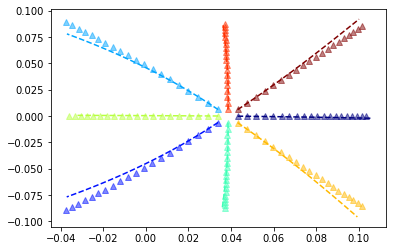

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.fc = nn.Linear(2,7)

    def forward(self, x):

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        output = self.fc(x)
        return output
    
with open('../demonstration_center_out_KF.pkl', 'rb') as fp:
    data = pickle.load(fp)
dataset = Dataset(data)

trials = range(0,8)#np.where(dataset.df['target'] in {dataset.uniqueTargets[0],dataset.uniqueTargets[4]})[0]
X = np.array(dataset.df['ee_vel'][trials])
y = np.array(dataset.df['joints_vel'][trials])
X = np.concatenate(X)[:,:2]
y = np.concatenate(y)
X = torch.tensor(X).float()
y = torch.tensor(y).float()
dataloader = DataLoader(TensorDataset(X, y), batch_size=2)

model = MLP(2,7)
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss() #nn.CrossEntropyLoss()    
train_loop(dataloader,model,loss,optimizer,epochs=100)
test_loop(dataloader,model,loss)

decoderEvaluation(model,dataset)

# Train autoencoder
- 7-2-7 autoencoder
- Input: joint_vel
- Output: joint_vel
- The encod-decoded joints_vel is closed enough to reproduce end-effector position sequence. 
- Structured latent space, however, it is not similer to end-effector space, meaning we cannot control the decoder.
- Alignment module is needed to align axes because "aligned_decoder" can reproduce edn-effector movements. 

In [9]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(7,2)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2,7)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
X = np.concatenate(dataset.df['joints_vel'])
y = np.concatenate(dataset.df['joints_vel'])
X = torch.tensor(X).float()
y = torch.tensor(y).float()
dataloader = DataLoader(TensorDataset(X, y), batch_size=2)

##
model = AE()
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss() #nn.CrossEntropyLoss()    
train_loop(dataloader,model,loss,optimizer,epochs=100)
test_loop(dataloader,model,loss)

Avg loss: 
 6.628105391541795e-05


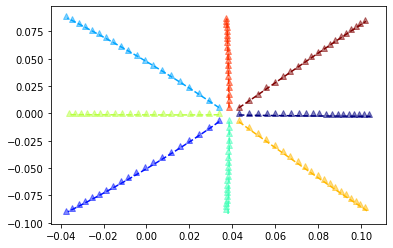

In [11]:
for target in dataset.uniqueTargets:
    color = dataset.colorOfTarget[target]
    env = PandaCenterOutEnv(render=False, control_type='joints')
    obs = env.reset()
    ee_pos = dataset.df[dataset.df['target']==target]['ee_pos'].iloc[0]
    ee_vel = dataset.df[dataset.df['target']==target]['ee_vel'].iloc[0]
    joints_vel = dataset.df[dataset.df['target']==target]['joints_vel'].iloc[0]
    ##
    latent = model.encoder(torch.tensor(joints_vel).float())
    decoded_joints_vel = model.decoder(latent)
    decoded_joints_vel = decoded_joints_vel.detach().numpy()
    decoded_pos = []
    for vel in decoded_joints_vel:
        obs, _, _, _ = env.step(vel)
        decoded_pos.append(obs['achieved_goal'])
    decoded_pos = np.array(decoded_pos)
    plt.plot(ee_pos[:,0],ee_pos[:,1],'^',color=color,alpha=0.5)
    plt.plot(decoded_pos[:,0],decoded_pos[:,1],'--',color=color)

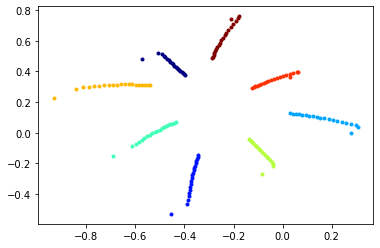

In [12]:
#Show latent space
for trial in range(len(dataset.df)):
    x = dataset.df['joints_vel'][trial]
    x = torch.tensor(x).float()
    target = dataset.df['target'][trial]
    color = dataset.colorOfTarget[target]
    latent = model.encoder(x).detach().numpy()
    plt.plot(latent[:,0],latent[:,1],'.',color=color)

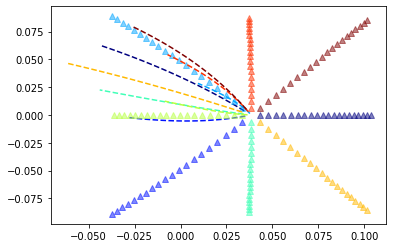

In [13]:
decoderEvaluation(model.decoder,dataset)

In [14]:
# Train alignment module
class AlignedDecoder(nn.Module):
    def __init__(self,decoder):
        super().__init__()
        self.align = torch.nn.Sequential(
            torch.nn.Linear(2,2))
        self.decoder = decoder
        for param in self.decoder.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.align(x)
        x = self.decoder(x)
        return x

In [15]:
X = np.concatenate(dataset.df['ee_vel'])
y = np.concatenate(dataset.df['joints_vel'])
X = torch.tensor(X).float()[:,:2]
y = torch.tensor(y).float()
dataloader = DataLoader(TensorDataset(X, y), batch_size=2)

aligned_decoder = AlignedDecoder(model.decoder)
optimizer = optim.Adam(aligned_decoder.parameters())
loss = nn.MSELoss() #nn.CrossEntropyLoss()    
train_loop(dataloader,aligned_decoder,loss,optimizer,epochs=100)

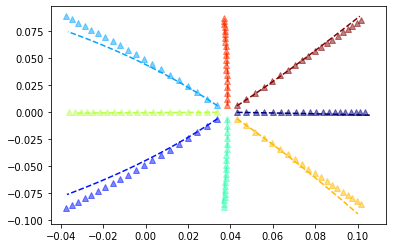

In [16]:
decoderEvaluation(aligned_decoder,dataset)

In [17]:
for name,param in model.named_parameters():
    print(name,param)

encoder.0.weight Parameter containing:
tensor([[ 0.6898, -0.3553,  0.4769, -0.3102, -0.5922, -0.0619,  0.7609],
        [ 0.4423,  0.3951,  0.4057,  0.4361, -0.2529, -0.3584,  0.5861]],
       requires_grad=True)
encoder.0.bias Parameter containing:
tensor([-0.2649,  0.1555], requires_grad=True)
decoder.0.weight Parameter containing:
tensor([[ 0.3390,  0.2195],
        [-0.3965,  0.5421],
        [ 0.1213,  0.0682],
        [-0.6155,  0.8395],
        [-0.0509, -0.0310],
        [ 0.2203, -0.2958],
        [ 0.4828,  0.3016]])
decoder.0.bias Parameter containing:
tensor([ 0.0582, -0.1896,  0.0187, -0.2884, -0.0184,  0.0989,  0.0778])


In [18]:
for name,param in aligned_decoder.named_parameters():
    print(name,param)

align.0.weight Parameter containing:
tensor([[-1.5973,  2.2473],
        [ 2.5090,  1.6476]], requires_grad=True)
align.0.bias Parameter containing:
tensor([-0.2736,  0.1649], requires_grad=True)
decoder.0.weight Parameter containing:
tensor([[ 0.3390,  0.2195],
        [-0.3965,  0.5421],
        [ 0.1213,  0.0682],
        [-0.6155,  0.8395],
        [-0.0509, -0.0310],
        [ 0.2203, -0.2958],
        [ 0.4828,  0.3016]])
decoder.0.bias Parameter containing:
tensor([ 0.0582, -0.1896,  0.0187, -0.2884, -0.0184,  0.0989,  0.0778])


# Train VAE
- Linear VAE, 7-2-7
- Input: joint_vel
- Output: joint_vel
- The encod-decoded joints_vel is closed enough to reproduce end-effector position sequence. 
- Structured latent space, however, it is not similer to end-effector space, meaning we cannot control the decoder.
- Alignment module is needed to align axes because "aligned_decoder" can reproduce edn-effector movements. 

Note: The training of VAE is not stable. Need to make sure the loss is low enough to reproduce end-effector movements. 

In [19]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=2):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(7, latent_dims)
        self.linear2 = nn.Linear(7, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear1(x)
        sigma = torch.exp(self.linear2(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(2, 7)

    def forward(self, z):
        z = self.linear1(z)
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims=2):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [20]:
X = np.concatenate(dataset.df['joints_vel'])
y = np.concatenate(dataset.df['joints_vel'])
X = torch.tensor(X).float()
y = torch.tensor(y).float()
dataloader = DataLoader(TensorDataset(X, y), batch_size=2)

##
model = VariationalAutoencoder()

def train_vae(autoencoder, data, epochs=100,kl_coef=0):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            
            X_hat = autoencoder(X)
            loss = ((y - X_hat)**2).sum() + autoencoder.encoder.kl*kl_coef
            opt.zero_grad()
            loss.backward()
            opt.step()
    return autoencoder
train_vae(model,dataloader,kl_coef=0)
test_loop(dataloader,model,loss)

Avg loss: 
 0.002082542301650392


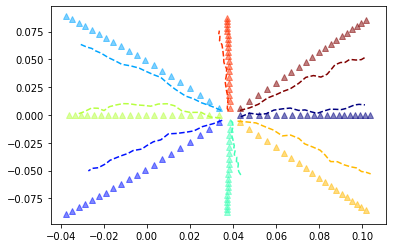

In [21]:
for target in dataset.uniqueTargets:
    color = dataset.colorOfTarget[target]
    env = PandaCenterOutEnv(render=False, control_type='joints')
    obs = env.reset()
    ee_pos = dataset.df[dataset.df['target']==target]['ee_pos'].iloc[0]
    ee_vel = dataset.df[dataset.df['target']==target]['ee_vel'].iloc[0]
    joints_vel = dataset.df[dataset.df['target']==target]['joints_vel'].iloc[0]
    ##
    latent = model.encoder(torch.tensor(joints_vel).float())
    decoded_joints_vel = model.decoder(latent)
    decoded_joints_vel = decoded_joints_vel.detach().numpy()
    decoded_pos = []
    for vel in decoded_joints_vel:
        obs, _, _, _ = env.step(vel)
        decoded_pos.append(obs['achieved_goal'])
    decoded_pos = np.array(decoded_pos)
    plt.plot(ee_pos[:,0],ee_pos[:,1],'^',color=color,alpha=0.5)
    plt.plot(decoded_pos[:,0],decoded_pos[:,1],'--',color=color)

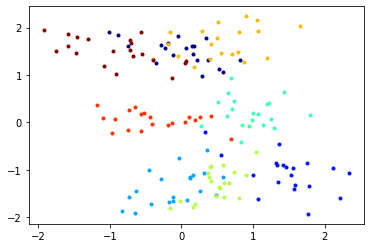

In [22]:
#Show latent space
for trial in range(len(dataset.df)):
    x = dataset.df['joints_vel'][trial]
    x = torch.tensor(x).float()
    target = dataset.df['target'][trial]
    color = dataset.colorOfTarget[target]
    latent = model.encoder(x).detach().numpy()
    plt.plot(latent[:,0],latent[:,1],'.',color=color)

In [23]:
X = np.concatenate(dataset.df['ee_vel'])
y = np.concatenate(dataset.df['joints_vel'])
X = torch.tensor(X).float()[:,:2]
y = torch.tensor(y).float()
dataloader = DataLoader(TensorDataset(X, y), batch_size=2)

aligned_decoder = AlignedDecoder(model.decoder)
optimizer = optim.Adam(aligned_decoder.parameters())
loss = nn.MSELoss() #nn.CrossEntropyLoss()    
train_loop(dataloader,aligned_decoder,loss,optimizer,epochs=100)

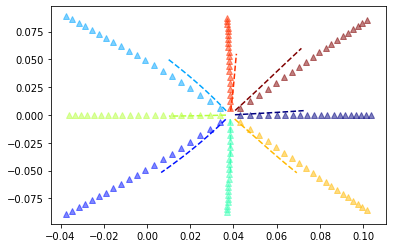

In [24]:
decoderEvaluation(aligned_decoder,dataset)

In [25]:
for name,param in model.named_parameters():
    print(name,param)

encoder.linear1.weight Parameter containing:
tensor([[-2.1431, -0.3438, -2.2621, -0.7010,  1.9386,  0.7654, -1.8537],
        [-0.0347,  1.9355, -0.3071,  2.2489,  0.2135, -1.6560, -0.5619]],
       requires_grad=True)
encoder.linear1.bias Parameter containing:
tensor([0.2576, 0.0393], requires_grad=True)
encoder.linear2.weight Parameter containing:
tensor([[ 0.1281,  0.3216, -0.1367, -0.2753,  0.2529,  0.1208,  0.1299],
        [-0.1299,  0.1854,  0.3971, -0.0626, -0.4043,  0.4280, -0.1362]],
       requires_grad=True)
encoder.linear2.bias Parameter containing:
tensor([-0.9259, -1.5085], requires_grad=True)
decoder.linear1.weight Parameter containing:
tensor([[-0.1177, -0.0383],
        [-0.0196,  0.1465],
        [-0.0398, -0.0122],
        [-0.0314,  0.2252],
        [ 0.0218,  0.0032],
        [ 0.0102, -0.0822],
        [-0.1657, -0.0538]])
decoder.linear1.bias Parameter containing:
tensor([ 0.0310, -0.0024,  0.0149,  0.0032, -0.0084, -0.0060,  0.0397])


In [26]:
for name,param in aligned_decoder.named_parameters():
    print(name,param)

align.0.weight Parameter containing:
tensor([[-2.1738, -5.8645],
        [ 5.9144, -0.5354]], requires_grad=True)
align.0.bias Parameter containing:
tensor([0.2368, 0.1098], requires_grad=True)
decoder.linear1.weight Parameter containing:
tensor([[-0.1177, -0.0383],
        [-0.0196,  0.1465],
        [-0.0398, -0.0122],
        [-0.0314,  0.2252],
        [ 0.0218,  0.0032],
        [ 0.0102, -0.0822],
        [-0.1657, -0.0538]])
decoder.linear1.bias Parameter containing:
tensor([ 0.0310, -0.0024,  0.0149,  0.0032, -0.0084, -0.0060,  0.0397])
